### Building chatbot with multiple tools using langGraph

### Aim

Create a chatbot with tool capabilities from arxiv , wikipedia search and some functions

In [1]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from  langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper


In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [9]:
arxiv.invoke("what newton's 2nd law .")

"Published: 1999-04-19\nTitle: What are the Hidden Quantum Processes Behind Newton's Laws?\nAuthors: Tom Ostoma, Mike Trushyk\nSummary: We investigate the hidden quantum processes that are responsible for Newton's\nlaws of motion and Newton's universal law of gravity. We apply Electro-Magnetic\nQuantum Gravity or EMQG to investigate Newtonian classical physics. EQMG is a\nquantum gravity theory that is manifestly compatible with Cellular Automata\n(CA) theory, a new paradigm for physical reality. EMQG i"

In [6]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki.name)

wikipedia


In [10]:
wiki.invoke("what newton's 2nd law .")

"Page: Newton's laws of motion\nSummary: Newton's laws of motion are three physical laws that describe the relationship between the motion of an object and the forces acting on it. These laws, which provide the basis for Newtonian mechanics, can be paraphrased as follows:\n\nA body remains at rest, or in motion at a constant speed in a straight line, unless it is acted upon by a force.\nAt any instant of time, the net force on a body is equal to the body's acceleration multiplied by its mass or, equi"

In [12]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


In [15]:

# Tavily Search Results Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily= TavilySearchResults()
print(tool.name)

tavily_search_results_json


In [17]:
tavily.invoke("Provide me the today news about AI developments.")

[{'title': 'AI News & Artificial Intelligence | TechCrunch',
  'url': 'https://techcrunch.com/category/artificial-intelligence/',
  'content': "Contact Us\n\n# AI\n\nNews coverage on artificial intelligence and machine learning tech, the companies building them, and the ethical issues AI raises today. This encompasses generative AI, including large language models, text-to-image and text-to-video models; speech recognition and generation; and predictive analytics.\n\n### \n\nA visitor walks past a computer bay at the PA10 data center, operated by Equinix Inc., in Paris, France. [...] ### Nvidia expands AI ties with Hyundai, Samsung, SK, Naver\n\nNvidia logo\n\n### Nvidia is reportedly investing up to $1B in Poolside\n\n### Bevel raises $10M Series A from General Catalyst for its AI health companion\n\nGoogle Gemini\n\n### Google partners with Ambani’s Reliance to offer free AI Pro access to millions of Jio users in India\n\n### Figma acquires AI-powered media generation company Weavy\n

In [18]:
### combine all the tools in the list 

tools = [arxiv, wiki, tavily]

In [25]:
## Initialize my llm model

from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.1-8b-instant")

llm.bind_tools(tools)

llm_with_tools= llm.bind_tools(tools)


In [26]:
from pprint import pprint
from langchain_core.messages import HumanMessage,AIMessage


llm_with_tools.invoke([HumanMessage(content=f"What is the recent AI News")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'eqqss3s96', 'function': {'arguments': '{"query":"Recent AI News"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 553, 'total_tokens': 573, 'completion_time': 0.030634919, 'prompt_time': 0.031880667, 'queue_time': 0.054371663, 'total_time': 0.062515586}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_33e8adf159', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--85871286-6274-4325-8e7f-e1f8c6aabcd6-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Recent AI News'}, 'id': 'eqqss3s96', 'type': 'tool_call'}], usage_metadata={'input_tokens': 553, 'output_tokens': 20, 'total_tokens': 573})

In [27]:
### Entire Chatbot With LangGraph
 
from IPython.display import display,Image
from langgraph.graph import StateGraph, START , END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition


In [ ]:
### state schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [30]:
### Node Definitions
def tool_calling_llm(state):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}


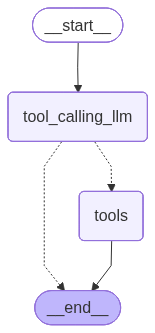

In [34]:
### Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
         "tool_calling_llm", 
                            # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is a not tool call -> tools_condition routes to END
                            
                             tools_condition,)

builder.add_edge("tools", END)


graph = builder.compile()

# view
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages = graph.invoke({"messages": HumanMessage(content="What is attention is all you need")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is attention is all you need
================================== Ai Message ==================================
Tool Calls:
  wikipedia (fncaw2ryb)
 Call ID: fncaw2ryb
  Args:
    query: Attention is All You Need
================================= Tool Message =================================
Name: wikipedia

Page: Attention Is All You Need
Summary: "Attention Is All You Need" is a 2017 landmark research paper in machine learning authored by eight scientists working at Google. The paper introduced a new deep learning architecture known as the transformer, based on the attention mechanism proposed in 2014 by Bahdanau et al. It is considered a foundational paper in modern artificial intelligence, and a main contributor to the AI boom, as the transformer approach has become the main architecture of a wi


In [36]:
messages = graph.invoke({"messages": HumanMessage(content="What is newtons 2nd law")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is newtons 2nd law
================================== Ai Message ==================================
Tool Calls:
  arxiv (sr8n22qb2)
 Call ID: sr8n22qb2
  Args:
    query: newton's second law
================================= Tool Message =================================
Name: arxiv

Published: 2015-02-15
Title: Newton's second law: not so elementary (as it may seem)
Authors: Ledo Stefanini, Giancarlo Reali
Summary: We propose an interpretation of the Newton's second law that is suggested by
Galilean Relativity theory.

Published: 2002-10-21
Title: Analise dinamica da tendencia para o equilibrio num modelo simples: a Segunda Lei de Newton e a Segunda Lei da Termodinamica
Authors: Rodrigo de Abreu
Summary: We relate Newton's Second Law with the Second Law of Thermodynamics th


In [40]:
messages = graph.invoke({"messages": HumanMessage(content="Provide me the latest AI news ")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the latest AI news 
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (actk121ze)
 Call ID: actk121ze
  Args:
    query: latest AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "The Latest AI News and AI Breakthroughs that Matter Most: 2025", "url": "https://www.crescendo.ai/news/latest-ai-news-and-updates", "content": "Summary: Xiaomi has announced a next-gen AI voice model optimized for in-car and smart home experiences. The model features faster response times, offline", "score": 0.98566}, {"title": "8 Key AI Developments Shaping 2025 - Koombea", "url": "https://ai.koombea.com/blog/key-ai-developments", "content": "The developments highlighted here – generative AI, AI copilots, coding AI, healthcare breakthroughs, AI in security, regulat

In [41]:
messages = graph.invoke({"messages": HumanMessage(content="What is machine learning")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (5rxqjfze2)
 Call ID: 5rxqjfze2
  Args:
    query: Machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML fi
